# COVID-19 Analysis

## Preliminaries

In [190]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tempfile
import requests
import zipfile
import datetime
from pathlib import Path
from IPython.display import display, Markdown
from functools import reduce
import humanize

In [191]:
print(f"Generated on {datetime.datetime.utcnow()} UTC")

Generated on 2021-07-28 07:05:32.516984 UTC


## Data retrieval
### Get OurWorldInData data

In [192]:
df = pd.read_csv("https://covid.ourworldindata.org/data/owid-covid-data.csv")
df.index = pd.to_datetime(df.date)
df["death_ratio"] = df.new_deaths_smoothed_per_million / df.new_cases_smoothed_per_million

### French data

In [242]:
fr_dep_df = pd.read_csv("https://www.data.gouv.fr/fr/datasets/r/5c4e1452-3850-4b59-b11c-3dd51d7fb8b5")
fr_dep_df.index = pd.to_datetime(fr_dep_df.date)

fr_df = pd.read_csv("https://www.data.gouv.fr/fr/datasets/r/f335f9ea-86e3-4ffa-9684-93c009d5e617")
fr_df.index = pd.to_datetime(fr_df.date)

/Users/pagessin/default_jupyter_kernel/venv/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3145: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


### Swiss data

In [194]:
r = requests.get("https://www.covid19.admin.ch/api/data/context", timeout=10)
url = r.json()["sources"]["zip"]["csv"]

with tempfile.TemporaryDirectory() as d:
    dl = Path(d) / "dl.zip"
#     print(dl.resolve())
    with requests.get(url, stream=True, timeout=10) as r:
        with dl.open("wb") as fh:
            r.raise_for_status()
            for chunk in r.iter_content(chunk_size=8192): 
                fh.write(chunk)

    with zipfile.ZipFile(fh.name) as z:
        with z.open("data/COVID19Cases_geoRegion.csv") as fh:
            ch_df = pd.read_csv(fh)
            
ch_df.index = pd.to_datetime(ch_df.datum)

In [195]:
r = requests.get("https://www.rki.de/DE/Content/InfAZ/N/Neuartiges_Coronavirus/Daten/Fallzahlen_Inzidenz_aktualisiert.xlsx?__blob=publicationFile", timeout=10)
ger_df = pd.read_excel(r.content, engine='openpyxl', sheet_name="BL_7-Tage-Fallzahl-aktualisiert")
ger_df = ger_df.transpose()
states = list(ger_df.iloc[0][4:])
ger_df = ger_df.iloc[1:]
ger_df = ger_df.drop([0, 1, 3], axis=1)
ger_df.columns = ["date"] + states
ger_df.index = pd.to_datetime(ger_df.date)
ger_df = ger_df.drop("date", axis=1)
ger_df = ger_df.iloc[:np.argmax(ger_df.isna().all(axis=1))] # remove everything after first all-NaN row
ger_df["Germany"] = ger_df.sum(axis=1)
# ger_df
ger_inc_df = ger_df[["Germany"]].copy()
ger_inc_df.Germany *= 1/83_100_000 * 100_000
# ger_inc_df

In [243]:
inc_df = reduce(lambda l, r: l.join(r, how="outer"), [
    fr_dep_df[fr_dep_df.lib_dep == "Ain"][["tx_incid"]].rename(columns={"tx_incid": "Ain"}),
    fr_df[["tx_incid"]].rename(columns={"tx_incid": "France"}),
    ch_df[ch_df.geoRegion == "GE"][["inzsum7d"]].rename(columns={"inzsum7d": "Geneva"}),
    ch_df[ch_df.geoRegion == "VD"][["inzsum7d"]].rename(columns={"inzsum7d": "Vaud"}),
    ch_df[ch_df.geoRegion == "CH"][["inzsum7d"]].rename(columns={"inzsum7d": "Switzerland"}),
    ger_inc_df,
])

## Incidences

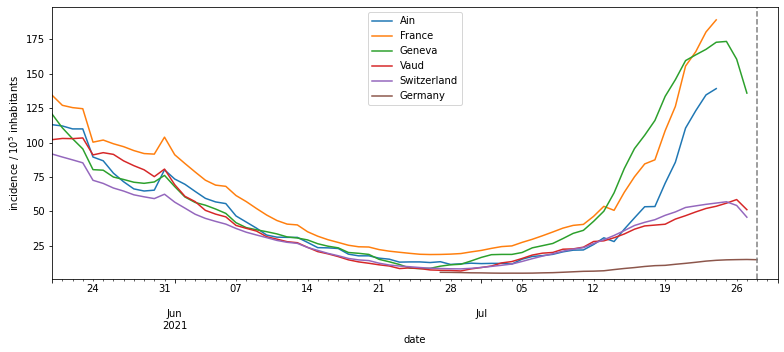

,Ain,France,Geneva,Vaud,Switzerland,Germany
2021-07-22,123.143899,165.967382,163.65,49.68,54.06,13.138387
2021-07-23,134.560206,180.238410,167.62,52.17,55.18,13.983153
2021-07-24,139.126729,189.012902,172.77,53.78,56.10,14.559567
2021-07-25,NaN,NaN,173.37,56.02,57.04,14.901324
2021-07-26,NaN,NaN,160.48,58.63,54.36,15.055355
2021-07-27,NaN,NaN,135.88,51.30,45.84,15.161252
2021-07-28,NaN,NaN,NaN,NaN,NaN,14.996390


In [270]:
fig, ax = plt.subplots(figsize=(13,5))
inc_df[inc_df.index > datetime.datetime.now() - datetime.timedelta(weeks=10)].plot(ax=ax)
# inc_df.tail(7*8).plot(ax=ax)
# ax.set_yscale("log")
ax.axvline(datetime.date.today(), ls="--", c="gray")
ax.set_ylim(bottom=1)
ax.set_xlim(right=datetime.date.today() + datetime.timedelta(days=2))
ax.set_xlabel("date")
ax.set_ylabel("incidence / $10^5$ inhabitants")
plt.show()
display(inc_df.tail(7))

In [269]:
idx = inc_df.notna()[::-1].idxmax()
tab_df = pd.DataFrame({"indicence": [inc_df.loc[i][c] for i, c in zip(idx, inc_df.columns)], 
                       "date": [humanize.naturaltime(dt) for dt in idx]}, index=inc_df.columns)
    
display(tab_df)

,indicence,date
Ain,139.126729,4 days ago
France,189.012902,4 days ago
Geneva,135.880000,a day ago
Vaud,51.300000,a day ago
Switzerland,45.840000,a day ago
Germany,14.996390,9 hours ago


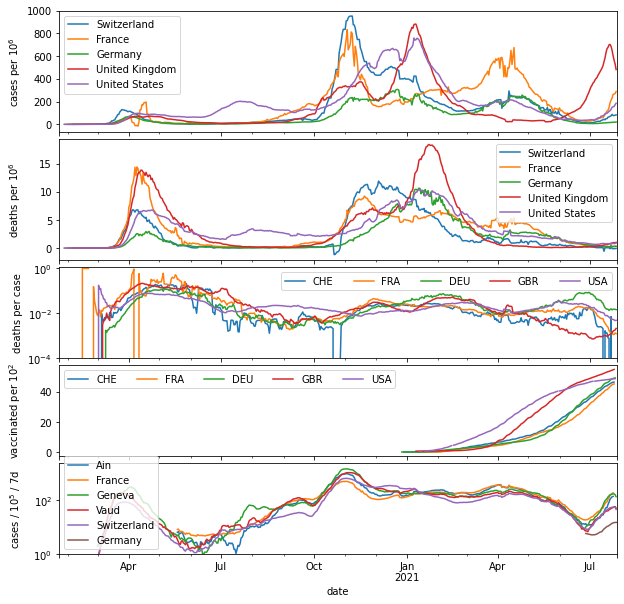

In [198]:
fig, axs = plt.subplots(5, 1, figsize=(10, 10), gridspec_kw={"height_ratios": [1, 1, 0.75, 0.75, 0.75], "hspace": 0.07}, sharex=True)
ax1, ax2, ax3, ax4, ax5 = axs
for country in (
    "CHE", 
    "FRA", 
    "DEU", 
    "GBR", 
    "USA",
):
    cdf = df[df.iso_code == country]
    
    name = cdf.location[0]
    cdf.plot(y="new_cases_smoothed_per_million", ax=ax1, label=name)
    cdf.plot(y="new_deaths_smoothed_per_million", ax=ax2, label=name)
   
    cdf.plot(y="death_ratio", ax=ax3, label=country)
    
    cdf.plot(y="people_fully_vaccinated_per_hundred", ax=ax4, label=f"{country}")
#     cdf.plot("date", "people_vaccinated_per_hundred", ax=ax3, ls="--", c=ax3.get_lines()[-1].get_color(), label=f"total")


# fr_dep_df[fr_dep_df.lib_dep == "Ain"].plot(y="tx_incid", ax=ax5, label="Ain")
# fr_df.plot(y="tx_incid", ax=ax5, label="France")
# ch_df[ch_df.geoRegion == "GE"].plot(y="inzsum7d", ax=ax5, label="Geneva")
# ch_df[ch_df.geoRegion == "VD"].plot(y="inzsum7d", ax=ax5, label="Vaud")
# ch_df[ch_df.geoRegion == "CH"].plot(y="inzsum7d", ax=ax5, label="Switzerland")
inc_df.plot(ax=ax5)
ax5.set_yscale("log")
ax5.set_ylim(bottom=1)

ax5.set_xlabel("date")
ax5.set_ylabel("cases / $10^5$ / 7d")

ax4.legend(ncol=5)
ax3.legend(ncol=5)

ax3.set_ylim(bottom=1e-4)
ax3.set_yscale("log")

ax1.set_ylabel("cases per $10^6$")
ax2.set_ylabel("deaths per $10^6$")
ax3.set_ylabel("deaths per case")
ax4.set_ylabel("vaccinated per $10^2$")

fig.align_ylabels()
# fig.tight_layout()
plt.show()

### Switzerland

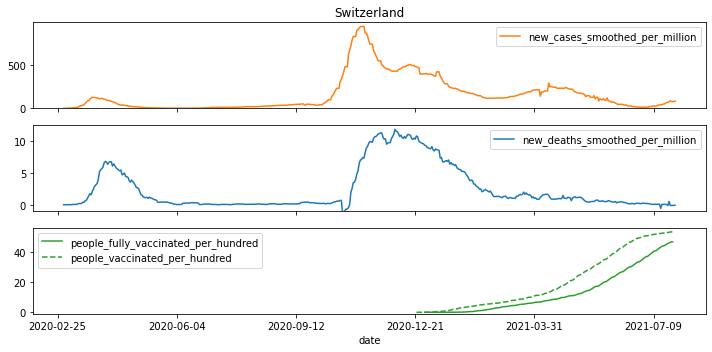

### France

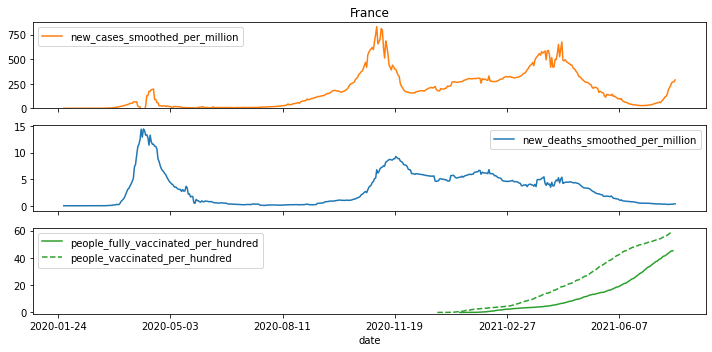

### Germany

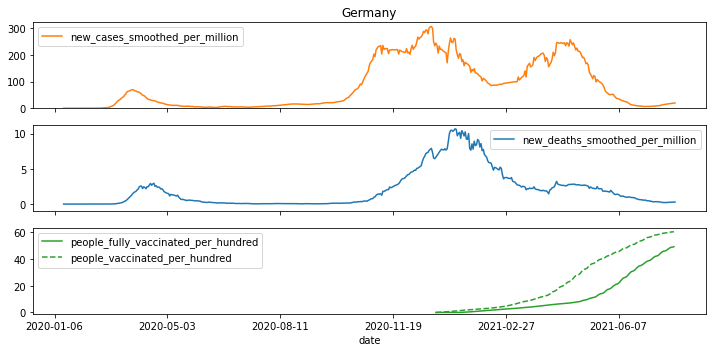

### United Kingdom

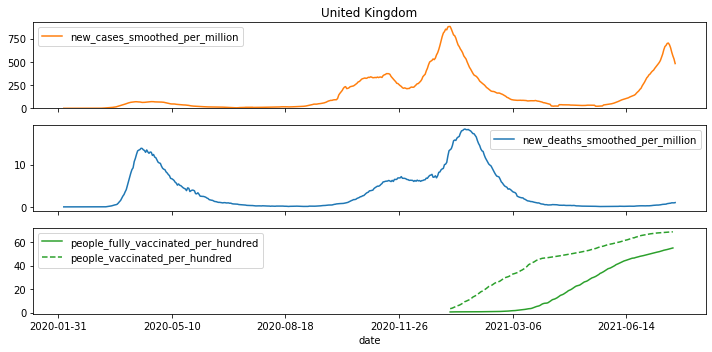

### United States

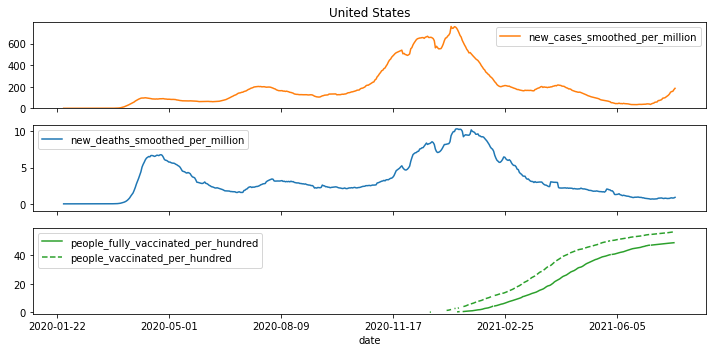

### Greece

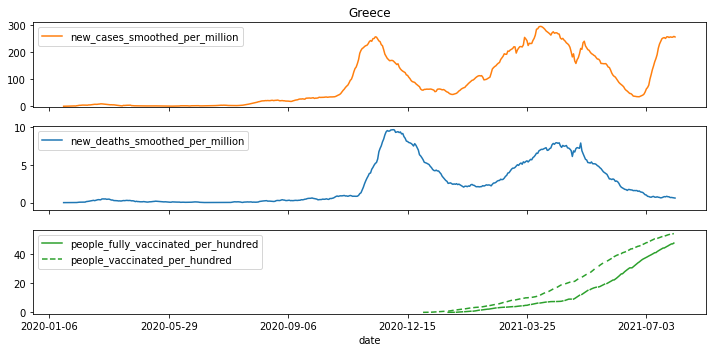

In [199]:
for country in (
    "CHE", 
    "FRA", 
    "DEU", 
    "GBR", 
    "USA",
    "GRC"
):
    cdf = df[df.iso_code == country]
    display(Markdown(f"### {cdf.location[0]}"))
    fig, axs = plt.subplots(3, 1, figsize=(10, 5), sharex=True)
    ax1, ax2, ax3 = axs
    cdf.plot("date", "new_cases_smoothed_per_million", ax=ax1, c="tab:orange")
    cdf.plot("date", "new_deaths_smoothed_per_million", ax=ax2, c="tab:blue")
    cdf.plot("date", "people_fully_vaccinated_per_hundred", ax=ax3, c="tab:green")
    cdf.plot("date", "people_vaccinated_per_hundred", ax=ax3, c="tab:green", ls="--")
    
    for ax in axs:
        ax.set_ylim(bottom=-1)

    ax1.set_title(cdf.location[0])
    fig.tight_layout()
    plt.show()